In [2]:
from helpers import *
import numpy as np
import pandas as pd
import math
import pickle
import matplotlib.pyplot as plt
import os
import scipy
from scipy import signal
from scipy.interpolate import pchip
from scipy import interpolate

inDir = '../'
dictName = 'jetVars'
#tracks = 'nom:RF75:RF75NB:loose:tight:A:B'.split(':')
workDir = '/Users/avalee/TrackingAnalysis/'
outDir = workDir + 'LLRplots'
if not (os.path.isdir(outDir)): os.makedirs(outDir)
styleDict = styleTracks()

ttbar = '410470'
Zext = '427081'
Z = '427080'

tracks ='nom:pseudo:ideal'.split(':')
tracks2 = 'nom:nom_RF75:nom_RF75_replaceFRAGWithTruth:nom_RF90'.split(':')
tracksAll = 'nom:nom_RF75:nom_RF75_replaceFRAGWithTruth:nom_RF90:pseudo:ideal'.split(':')
tracksRF = 'nom:nom_RF75:nom_RF75NB:nom_RFNBMVA_A:nom_RFNBMVA_B'.split(':')
tracks3 = 'nom:pseudo:ideal:427081_nom'.split(':')


In [3]:
with open('../410470_250_400_nom_RFNBMVA_A_jetVars.pickle', 'rb') as handle:
    varsDict = pickle.load(handle)
df = pd.DataFrame.from_dict(varsDict)
df.query('jet_jf_sig3d > 0')

,jet_jf_nvtx,c,b,jet_jf_ntrkAtVx,jet_LabDr_HadF,jet_jf_llr,jet_jf_sig3d,l
0,0.0,4920,18864,0.0,0,-3.459392,23.758242,30852
1,1.0,4920,18864,4.0,0,-1.897191,57.168301,30852
2,1.0,4920,18864,2.0,0,-3.016649,5.850849,30852
3,1.0,4920,18864,2.0,5,0.004840,40.494961,30852
5,0.0,4920,18864,0.0,5,-2.831614,4.401948,30852
...,...,...,...,...,...,...,...,...
54627,1.0,4920,18864,4.0,5,2.259238,29.669239,30852
54628,1.0,4920,18864,2.0,5,-0.983511,27.473375,30852
54630,1.0,4920,18864,2.0,5,-2.313691,11.725282,30852
54631,1.0,4920,18864,3.0,0,0.160690,10.793297,30852


In [4]:
def getLLRvalues(inDir, version, tracks, dictName, add_cuts="", rej=True):  
    nbins = 1400
    # Remember to change these values for jet_jf_sig3d!
    xMin = 0
    xMax = 80
    xRange = [xMin, xMax]
    LLR_values = {}
    
    for track in tracks:
        print (track)
        varsDict = getDict(inDir, version, track, dictName)
        df = pd.DataFrame.from_dict(varsDict)
        
        if add_cuts != "":
            df.query(add_cuts, inplace=True)

        jets = {"b": 5, "c": 4, "l": 0}
        tot = {}
        llr = {}
        freqs = {}
        for jet in jets.keys():
            tot[jet] = varsDict[jet]
            #llr[jet] = df.query('jet_LabDr_HadF ==' + str(jets[jet]) + ' & jet_jf_llr !=-99')['jet_jf_llr'].tolist()
            llr[jet] = df.query('jet_LabDr_HadF ==' + str(jets[jet]) + ' & jet_jf_sig3d !=-100')['jet_jf_sig3d'].tolist()
            freqs[jet], _ , _ = plt.hist(llr[jet], range=(xMin, xMax), bins=nbins)
            
        
        print (tot['b'])
        print (len(llr['b'])/tot['b'])
        if tot['b'] == 0: effPoints = []
        else: effPoints = np.linspace(0.1, 1, nbins)
        l_s = []
        c_s = []
        for eff in effPoints:
            if eff < len(llr['b'])/tot['b']: # less than max b eff
                # solve for t
                cut = inverseFunction(eff,lambda x: integrateHist(freqs['b']/tot['b'],[x,xMax],xRange,nbins),xRange,-1)
                l_eff = integrateHist(freqs['l'], [cut, xMax], xRange, nbins)/tot['l']
                c_eff = integrateHist(freqs['c'], [cut, xMax], xRange, nbins)/tot['c']
                if rej:
                    if l_eff == 0: l_eff = 10e-7
                    if c_eff == 0: c_eff = 10e-7
                        
                    l_s.append(1/l_eff)
                    c_s.append(1/c_eff)
                else:
                    l_s.append(l_eff)
                    c_s.append(c_eff)

        LLR_values[track + '_b'] = effPoints[:len(l_s)]
        LLR_values[track + '_c'] = c_s
        LLR_values[track + '_l'] = l_s

    
    return LLR_values
        


def configureRatioPads(jet1, jet2, xMin, xMax, rej=True):
    fig = setStyle()
    gs = gridspec.GridSpec(2,1 , height_ratios=[4,1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    fig.subplots_adjust(hspace=0.07)
    fig.align_ylabels()
    
    # Settings for x and y-axis
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    if jet2 == "c":
        if rej: ax1.set_ylabel(r'$%s$-jet rejection' % (jet2), horizontalalignment='right', y=1.0)
        else: ax1.set_ylabel(r'$%s$-jet efficiency' % (jet2), horizontalalignment='right', y=1.0)
    else:
        if rej: ax1.set_ylabel(r'$light$-jet rejection', horizontalalignment='right', y=1.0)
        else: ax1.set_ylabel(r'$light$-jet efficiency', horizontalalignment='right', y=1.0)
    ax1.set_xlim([xMin, xMax])
    if rej: ax1.set_yscale('log')

    ax2.set_ylabel("Ratio", horizontalalignment='right', y=1.0)
    ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax2.set_xlabel(r'$%s$-jet efficiency' % (jet1), horizontalalignment='right', x=1.0)
    ax2.set_xlim([xMin, xMax])
    ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    
    return ax1, ax2


def wsize(y_array):
    w = int(len(y_array)/10)
    if w%2 == 0:
        w += 1
    return w

def plotLLRrocs(LLR_dict, version, tracks, jet1, jet2, xMin, xMax, outDir, xT=0.6, 
                add_text='', add_filename='', rej=True, leg_xy=[0.02, 0.01]):
    figName = "ROC_" + version + "_" + jet1 + jet2
    if add_filename != '': figName += '_' + add_filename
    if not rej: figName += '_eff'
    oth_nom = LLR_dict['nom_' + jet2]
    
    # Plot histograms
    ax1, ax2 = configureRatioPads(jet1, jet2, xMin, xMax, rej)
    for track in tracks:
        figName += '_' + track
        beffs = LLR_dict[track + '_' + jet1] 
        if len(beffs) == 0: continue
        oth = LLR_dict[track + '_' + jet2]
        
        ax1.plot(beffs, oth, color=styleDict[track][0], label=styleDict[track][1])
        f = pchip(beffs, oth)
        if len(oth_nom) != 0:
            if track == 'nom':
                f0 = f
                ratio = np.ones(len(beffs))
                ratio_ix = 1
            else:
                ratio = f(beffs) / f0(beffs)
                ratio_ix = f(oth) / f0(oth)
        ax2.plot(beffs,ratio, color=styleDict[track][0], linewidth=1)
  
    ax1.legend(bbox_to_anchor=leg_xy, loc='lower left', labelspacing=0.3, facecolor='none', edgecolor='none', prop={'size': 8})

    plt.text(xT, 0.95, "ATLAS Internal", fontsize=9, transform=ax1.transAxes, weight='bold', style='italic')
    if '410470' in version: text = r'410470 ttbar'
    if '427080' in version: text = r"427080 Z'"
    if '427081' in version: text = r"427081 Z' ext"
    plt.text(xT, 0.91, text, fontsize=9, transform=ax1.transAxes)
    plt.text(xT, 0.87, add_text, fontsize=9, transform=ax1.transAxes)

    plt.savefig(outDir + "/" + figName + ".pdf", bbox_inches='tight', pad_inches=0.04)


In [5]:
pTDict = {
    'le_150': r'$p_T$ < 150 GeV',
    '150_400': r'150 GeV < $p_T$ < 400 GeV',
    '400_1000': r'400 GeV < $p_T$ < 1 TeV',
    '1000_1750': r'1 TeV < $p_T$ < 1.75 TeV',
}

In [6]:
pTDictRF = {
    'le_250': r'$p_T$ < 250 GeV',
    '250_400': r'250 GeV < $p_T$ < 400 GeV',
    '400_1000': r'400 GeV < $p_T$ < 1 TeV',
    'ge_1000': r'$p_T$ > 1 TeV',
}

nom
12658
0.9313477642597566


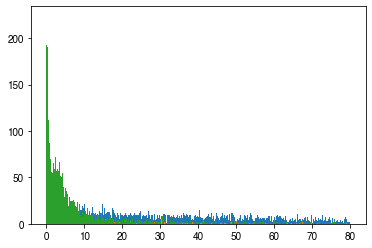

In [7]:
version = ttbar
name = '250_400'
version_new = version + '_' + name
LLRs = getLLRvalues(inDir, version_new, ['nom'], dictName)


In [ ]:
plotLLRrocs(LLRs, version_new, tracksRF, 'b', 'c', 0.1, 0.9, outDir)

In [9]:
def pTROCs(pTDict, version, tracks, dictName, outDir, xTLong=0.6, xTShort=0.7):
    for j in ['l', 'c']:
        for name, text in pTDict.items():
            print (name)
            version_new = version + '_' + name
            LLRs = getLLRvalues(inDir, version_new, tracks, dictName)
            if 'e' not in name:
                plotLLRrocs(LLRs, version_new, tracks, 'b', j, 0.1, 0.9, outDir, xTLong, text)
            else:
                plotLLRrocs(LLRs, version_new, tracks, 'b', j, 0.1, 0.9, outDir, xTShort, text)


In [ ]:
pTROCs(pTDict, Z, tracks3, dictName, outDir)

le_250
nom
94564
0.9192821792648365
nom_RF75
94564
0.9128738209043611
nom_RF75NB
94564
0.9161520240260564
nom_RFNBMVA_A
142359
0.9142519967125367
nom_RFNBMVA_B
142359
0.9160994387428965
250_400
nom
69820
0.9233314236608422
nom_RF75
69820
0.9098539100544256
nom_RF75NB
69820
0.9164136350615869
nom_RFNBMVA_A
104553
0.9094239285338537
nom_RFNBMVA_B
104553
0.9129914971354242
400_1000
nom
299447
0.888067003509803
nom_RF75
299447
0.8482469351838555
nom_RF75NB
299447
0.8678764522603332
nom_RFNBMVA_A
450407
0.85475802995957
nom_RFNBMVA_B
450407
0.8644315030627855
ge_1000
nom
1269904
0.8636117375801635
nom_RF75
1269904
0.7881682394889692
nom_RF75NB
1269904
0.820539190363996
nom_RFNBMVA_A
1910939
0.7374191431542294
nom_RFNBMVA_B
1910939
0.7854217219911258
le_250
nom
94564
0.9192821792648365
nom_RF75
94564
0.9128738209043611
nom_RF75NB
94564
0.9161520240260564
nom_RFNBMVA_A
142359
0.9142519967125367
nom_RFNBMVA_B
142359
0.9160994387428965
250_400
nom
69820
0.9233314236608422
nom_RF75
69820
0.90985

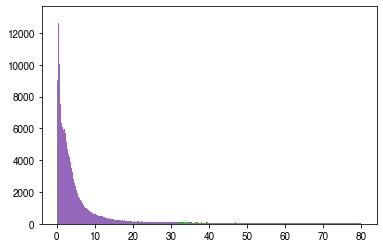

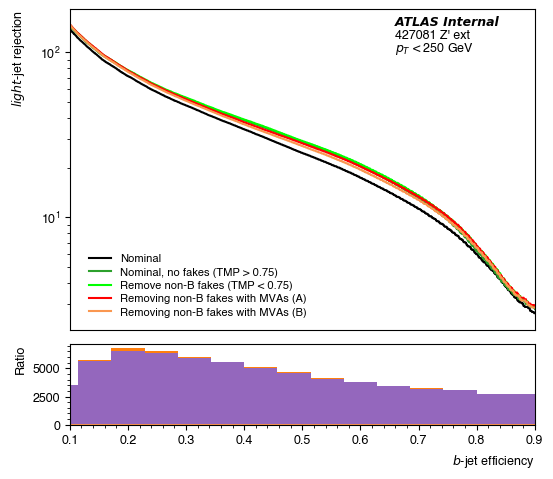

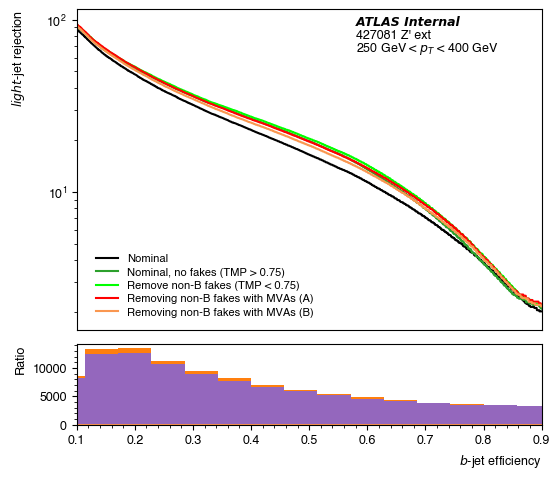

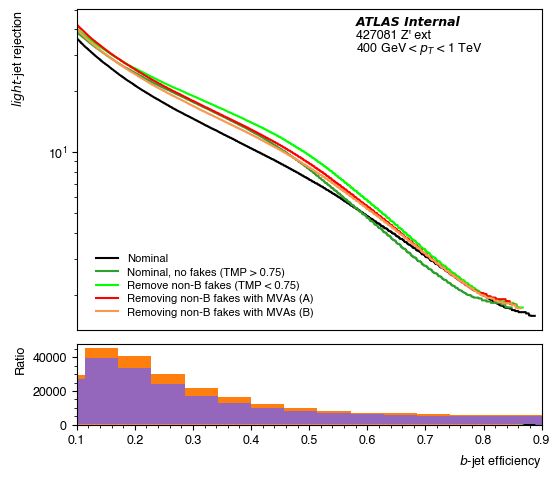

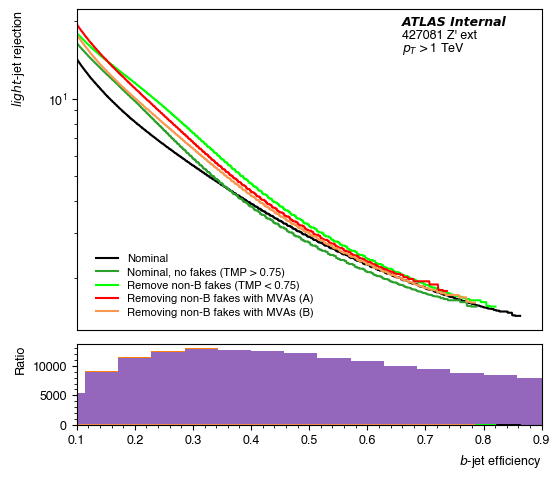

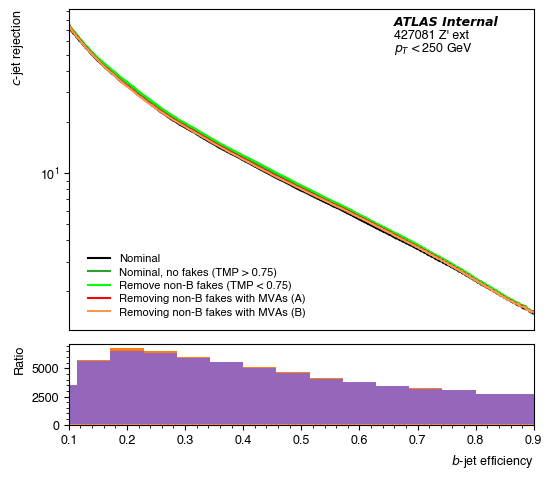

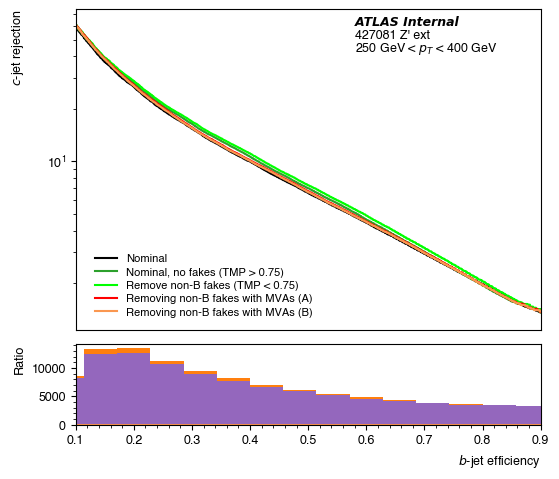

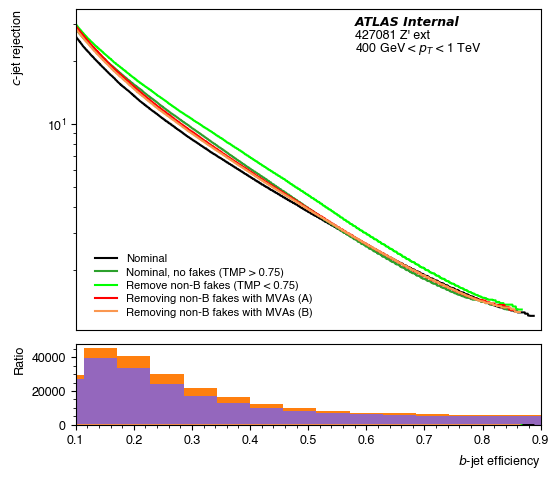

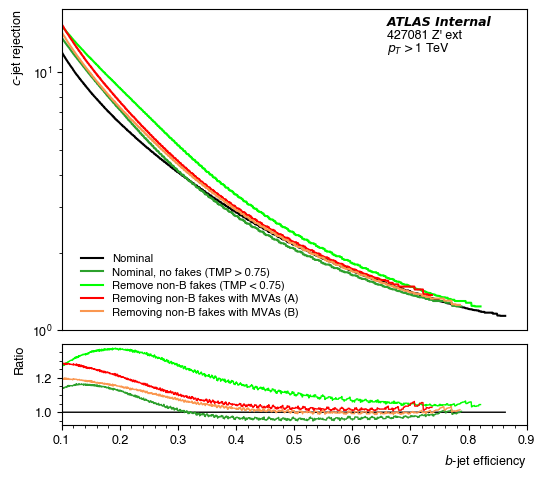

In [10]:
pTROCs(pTDictRF, Zext, tracksRF, dictName, outDir)